**Assignment 3: Reverse engineering predator prey system**

Esther Bakels, Loes Bijman, Sacha Gijsbers

Import data and recreate plot

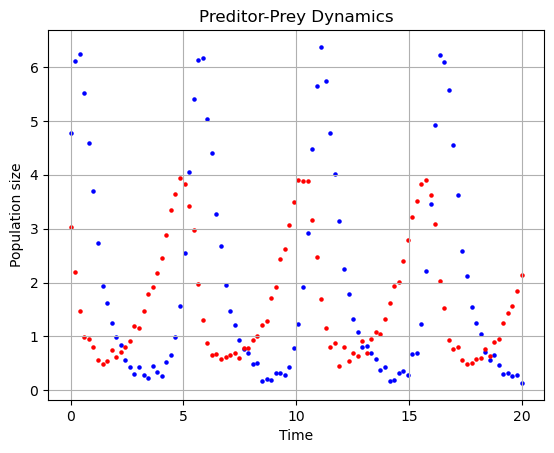

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# import data from csv
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")

# split data for two y axises
plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (preditor)')
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'y (prey)')
t = []
for i in range(0, 21, 5):
    t.append(i)
plt.xticks(t)

# show plot
plt.show()

In [20]:
print(f"Initial amount of prey: {df['x'][0]}")
print(f"Initial amount of predators: {df['y'][0]}")

Initial amount of prey: 4.78163509155479
Initial amount of predators: 3.03525735602479


Implement the system of ODEs

In [13]:
from scipy.integrate import odeint
import numpy as np

def lotka_volterra(init, t, alpha, beta, gamma, delta):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt


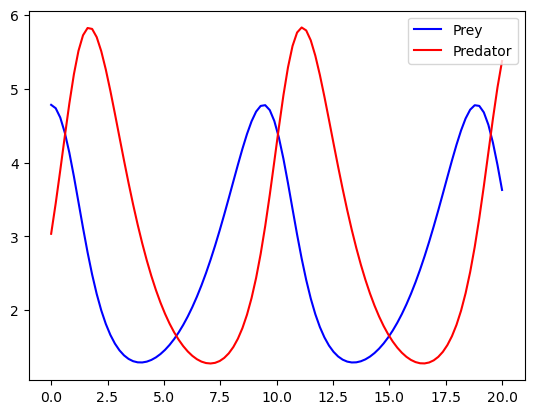

In [28]:
# take initial conditions from data set
x0 = 4.78163509155479
y0 = 3.03525735602479

init = [x0,y0]

alpha = 0.6
beta = 0.2
delta = 0.8
gamma = 0.3

t = np.linspace(0,20,100)

out = odeint(lotka_volterra, init, t, args = (alpha,beta,delta,gamma))

x, y = out.T[0], out.T[1]

plt.plot(t, x, label = 'Prey', color = 'b')
plt.plot(t, y, label = 'Predator', color = 'r')
plt.legend()
plt.show()

In [38]:
# label the data and turn to array
data = np.concatenate((np.array(df['x']),np.array(df['y'])))

In [ ]:
from scipy.optimize import minimize

def abs_residual(init, t, alpha, beta, delta, gamma):
    out = odeint(lotka_volterra, init, t, args = (alpha,beta,delta,gamma))
    return np.linalg.norm(out - data)**2